In [27]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# 检查 GPU 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 数据加载与预处理
transform = transforms.Compose([transforms.Resize((224, 224)),  # ResNet 要求输入尺寸
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# 加载 CIFAR-10 数据集
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 加载预训练的 ResNet 模型
resnet = torchvision.models.resnet18(pretrained=True)
resnet.fc = nn.Identity()  # 去掉最后的分类层，保留特征提取部分
resnet.to(device)  # 将模型移动到 GPU
resnet.eval()

# 提取特征函数
def extract_features(loader, model, device):
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Extracting features"):  # tqdm 显示进度
            images = images.to(device)  # 将输入数据移动到 GPU
            outputs = model(images)  # 提取特征
            features.append(outputs.cpu())  # 移动回 CPU
            labels.append(targets)
    features = torch.cat(features).numpy()
    labels = torch.cat(labels).numpy()
    return features, labels

# 提取训练和测试集的特征
print("Extracting features using ResNet on GPU...")
X_train, y_train = extract_features(train_loader, resnet, device)
X_test, y_test = extract_features(test_loader, resnet, device)



Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


D:\Anaconda\envs\pytorch_xiufu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\pytorch_xiufu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting features using ResNet on GPU...


Extracting features: 100%|██████████| 157/157 [00:13<00:00, 11.63it/s]


Training Logistic Regression...


D:\Anaconda\envs\pytorch_xiufu\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training LightGBM...
Training Random Forest...
Metrics for all models:
LogisticRegression: {'accuracy': 0.8697, 'precision': 0.8695387610932326, 'recall': 0.8696999999999999, 'f1': 0.8694775004219629}
LightGBM: {'accuracy': 0.8651, 'precision': 0.8654258877441648, 'recall': 0.8651, 'f1': 0.8650546535962198}
RandomForest: {'accuracy': 0.8155, 'precision': 0.8165932825496409, 'recall': 0.8155000000000001, 'f1': 0.8151093927789397}


In [33]:

# 定义评估函数
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# 保存指标的字典
metrics = {}

# 逻辑回归分类
print("Training Logistic Regression...")
log_reg = LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs', random_state=42)
log_reg.fit(X_train, y_train)
metrics['LogisticRegression'] = evaluate_model(log_reg, X_test, y_test)

# LightGBM 分类
print("Training LightGBM...")
lgb_train = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'multiclass',
    'num_class': 10,  # CIFAR-10 有 10 个类别
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'verbose': -1,
    'random_state': 42
}
lgb_model = lgb.train(params, lgb_train, num_boost_round=100)
y_pred_lgb = lgb_model.predict(X_test)
y_pred_lgb = y_pred_lgb.argmax(axis=1)  # 获取预测的类别
metrics['LightGBM'] = {
    'accuracy': accuracy_score(y_test, y_pred_lgb),
    'precision': precision_score(y_test, y_pred_lgb, average='macro'),
    'recall': recall_score(y_test, y_pred_lgb, average='macro'),
    'f1': f1_score(y_test, y_pred_lgb, average='macro')
}

# 随机森林分类
print("Training Random Forest...")
random_forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
random_forest.fit(X_train, y_train)
metrics['RandomForest'] = evaluate_model(random_forest, X_test, y_test)

# 打印保存的指标
print("Metrics for all models:")
for model_name, model_metrics in metrics.items():
    print(f"{model_name}: {model_metrics}")

Training Logistic Regression...


D:\Anaconda\envs\pytorch_xiufu\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training LightGBM...
Training Random Forest...
Metrics for all models:
LogisticRegression: {'accuracy': 0.8712, 'precision': 0.8711770729872466, 'recall': 0.8712, 'f1': 0.8710284919403394}
LightGBM: {'accuracy': 0.8651, 'precision': 0.8654258877441648, 'recall': 0.8651, 'f1': 0.8650546535962198}
RandomForest: {'accuracy': 0.8155, 'precision': 0.8165932825496409, 'recall': 0.8155000000000001, 'f1': 0.8151093927789397}


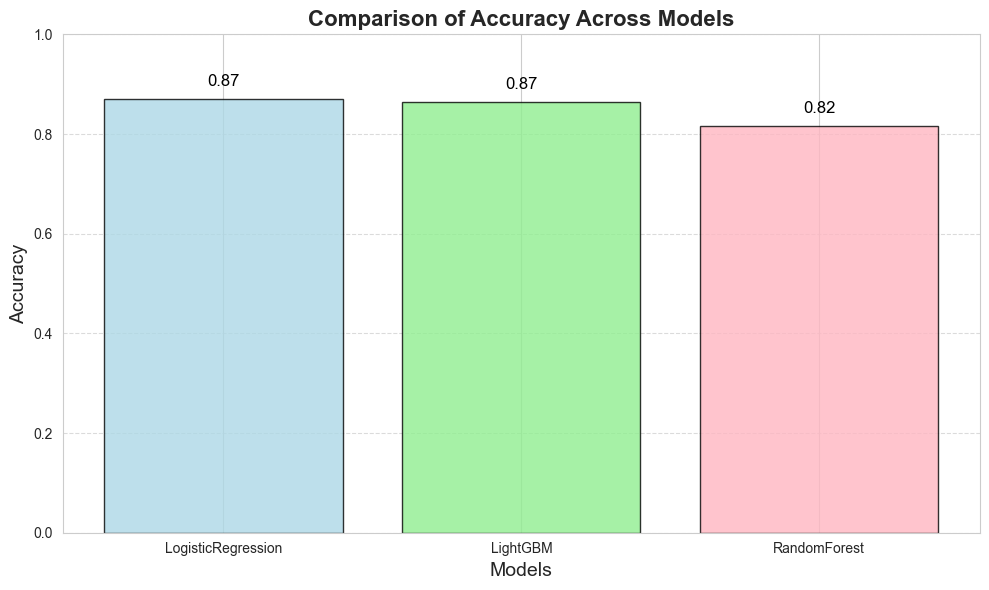

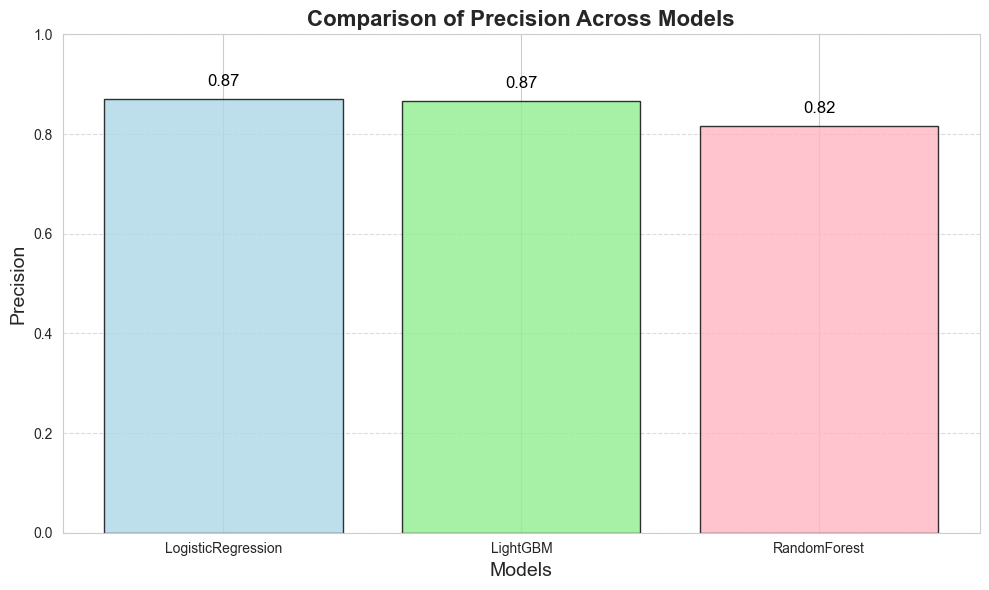

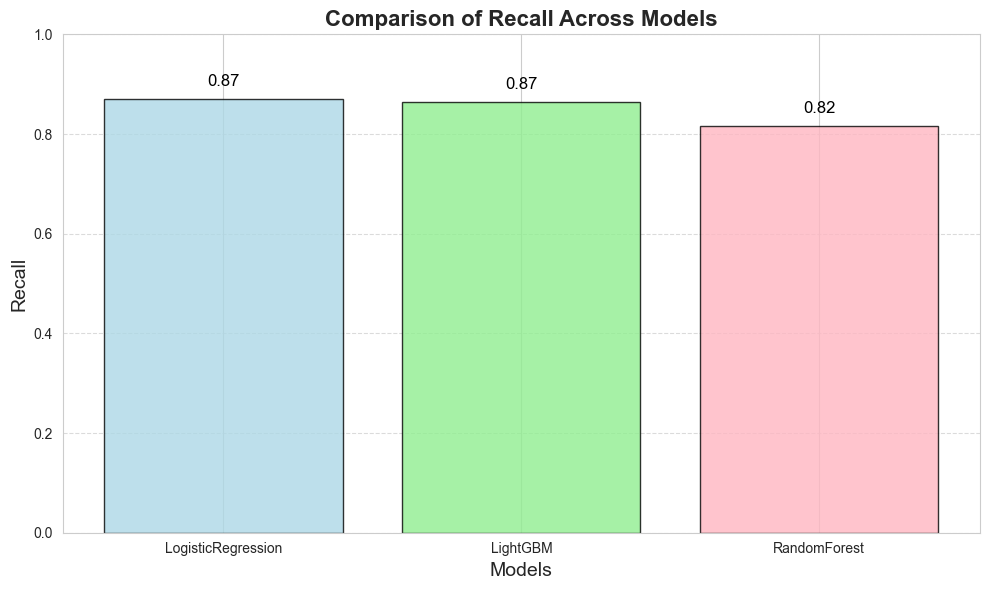

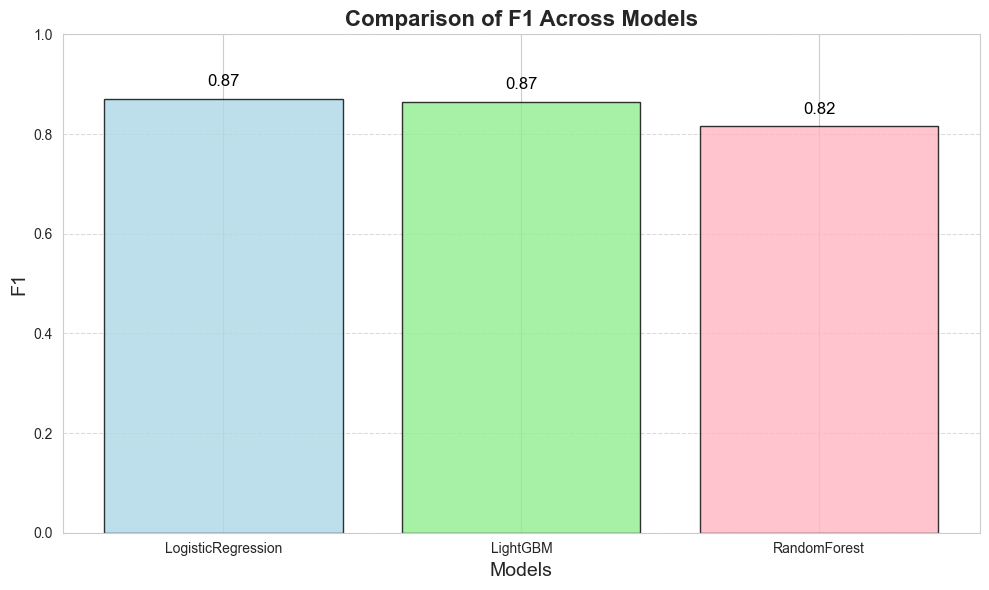

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# 可视化指标的高级柱状图
def plot_metrics(metrics):
    metrics_names = ['accuracy', 'precision', 'recall', 'f1']
    model_names = list(metrics.keys())
    
    # 设置浅色系配色
    colors = ['#ADD8E6', '#90EE90', '#FFB6C1', '#FFDAB9']
    
    for metric_name in metrics_names:
        values = [metrics[model][metric_name] for model in model_names]
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(model_names, values, color=colors, alpha=0.8, edgecolor='black')
        
        # 添加数值标注
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}",
                     ha='center', va='bottom', fontsize=12, color='black')
        
        # 美化图形
        plt.title(f"Comparison of {metric_name.capitalize()} Across Models", fontsize=16, fontweight='bold')
        plt.ylabel(metric_name.capitalize(), fontsize=14)
        plt.xlabel("Models", fontsize=14)
        plt.ylim(0, 1)  # 设置 y 轴范围为 0 到 1
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # 保存或展示图像
        plt.tight_layout()
        plt.show()

# 调用绘图函数
plot_metrics(metrics)


Performing K-means clustering...


D:\Anaconda\envs\pytorch_xiufu\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Reducing dimensions with PCA...


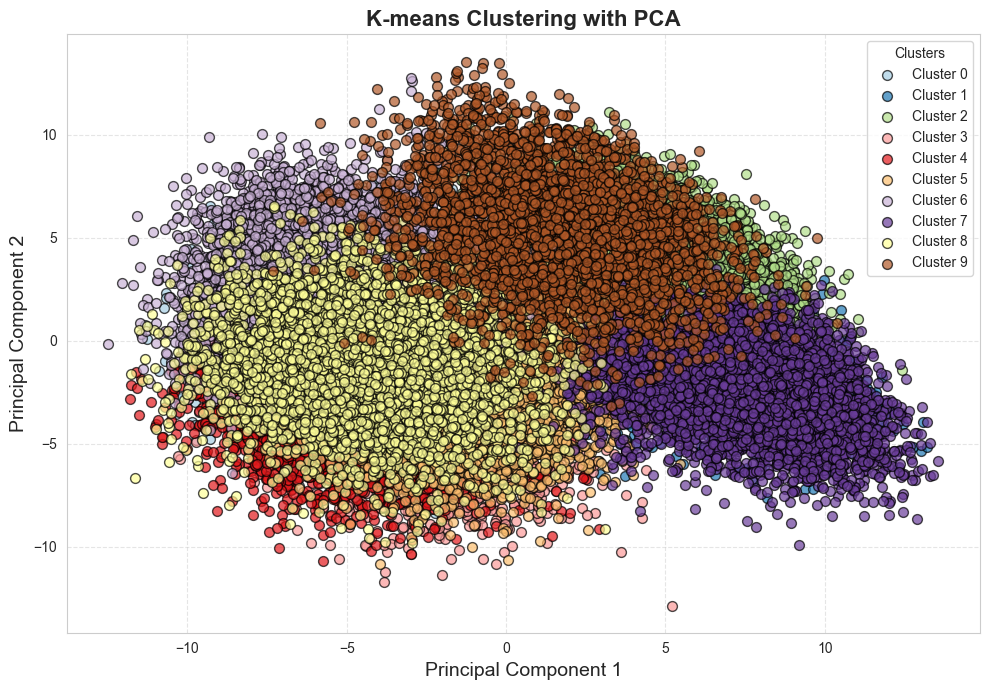

In [9]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# 使用 K-means 聚类
print("Performing K-means clustering...")
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_train)

# 使用 PCA 将数据降至 2 维
print("Reducing dimensions with PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# 绘制聚类结果的散点图
def plot_clusters(X, labels, title="K-means Clustering with PCA"):
    plt.figure(figsize=(10, 7))
    
    # 获取唯一的簇标签
    unique_labels = np.unique(labels)
    colors = plt.cm.Paired(np.linspace(0, 1, len(unique_labels)))  # 使用一组颜色
    
    for label, color in zip(unique_labels, colors):
        cluster_points = X[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    s=50, label=f"Cluster {label}", color=color, alpha=0.7, edgecolor='k')
    
    # 美化图形
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Principal Component 1", fontsize=14)
    plt.ylabel("Principal Component 2", fontsize=14)
    plt.legend(title="Clusters", fontsize=10)
    plt.grid(alpha=0.5, linestyle='--')
    plt.tight_layout()
    plt.show()

# 调用函数绘制散点图
plot_clusters(X_pca, kmeans_labels)


Evaluating log...

Classification Report for log:

              precision    recall  f1-score   support

           0     0.8853    0.8800    0.8826      1000
           1     0.9288    0.9260    0.9274      1000
           2     0.8452    0.8190    0.8319      1000
           3     0.7724    0.7670    0.7697      1000
           4     0.8276    0.8640    0.8454      1000
           5     0.8409    0.8140    0.8272      1000
           6     0.8724    0.9090    0.8903      1000
           7     0.9039    0.8750    0.8892      1000
           8     0.9094    0.9330    0.9210      1000
           9     0.9259    0.9250    0.9255      1000

    accuracy                         0.8712     10000
   macro avg     0.8712    0.8712    0.8710     10000
weighted avg     0.8712    0.8712    0.8710     10000



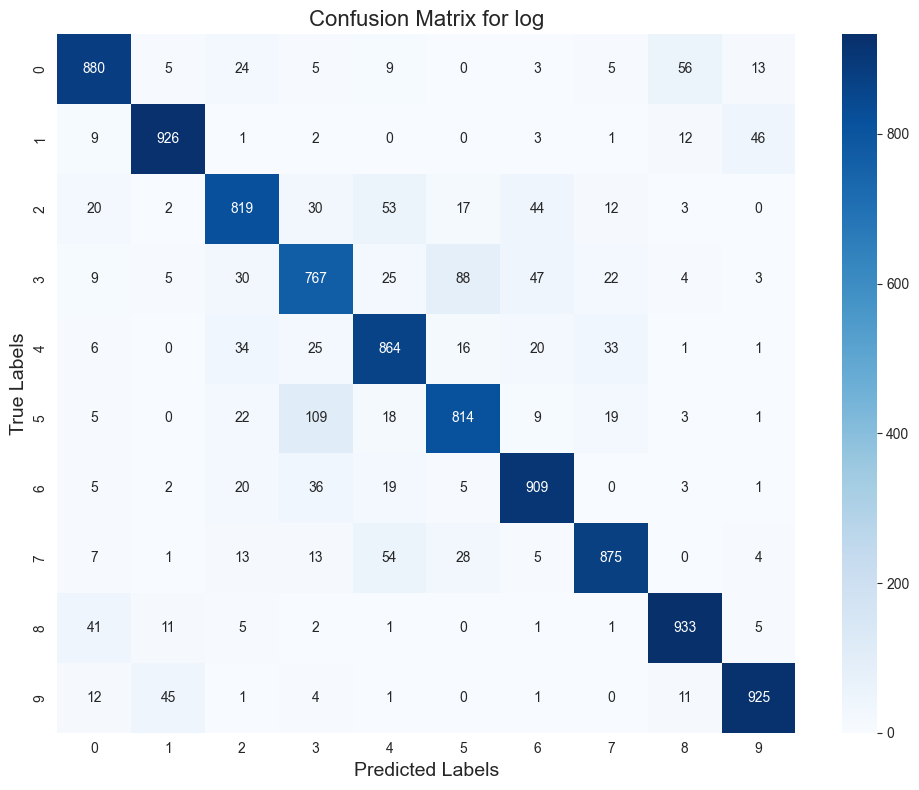

Evaluating LightGBM...

Classification Report for LightGBM:

              precision    recall  f1-score   support

           0     0.8765    0.8940    0.8851      1000
           1     0.9245    0.9060    0.9152      1000
           2     0.8470    0.7970    0.8212      1000
           3     0.7553    0.7840    0.7694      1000
           4     0.8343    0.8410    0.8376      1000
           5     0.8304    0.8130    0.8216      1000
           6     0.8769    0.9190    0.8975      1000
           7     0.8872    0.8650    0.8759      1000
           8     0.9051    0.9250    0.9149      1000
           9     0.9171    0.9070    0.9120      1000

    accuracy                         0.8651     10000
   macro avg     0.8654    0.8651    0.8651     10000
weighted avg     0.8654    0.8651    0.8651     10000



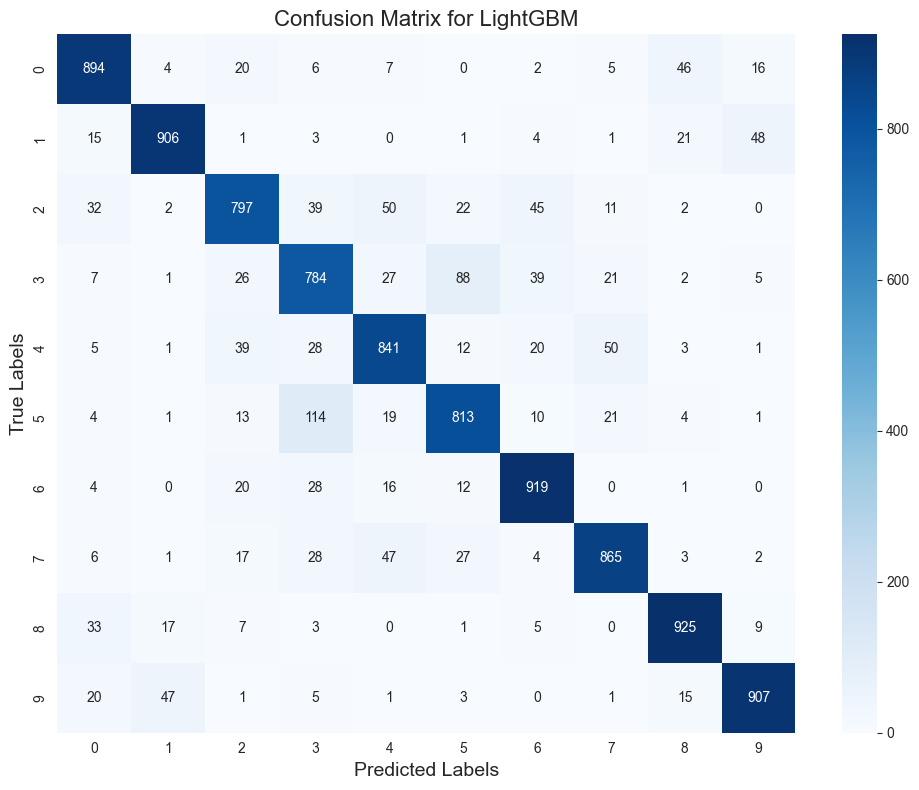

Evaluating Random Forest...

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0     0.8208    0.8520    0.8361      1000
           1     0.8943    0.9050    0.8996      1000
           2     0.8063    0.6950    0.7465      1000
           3     0.6697    0.7420    0.7040      1000
           4     0.7510    0.7510    0.7510      1000
           5     0.8079    0.7360    0.7703      1000
           6     0.8207    0.8790    0.8489      1000
           7     0.8364    0.8080    0.8220      1000
           8     0.8801    0.9030    0.8914      1000
           9     0.8787    0.8840    0.8814      1000

    accuracy                         0.8155     10000
   macro avg     0.8166    0.8155    0.8151     10000
weighted avg     0.8166    0.8155    0.8151     10000



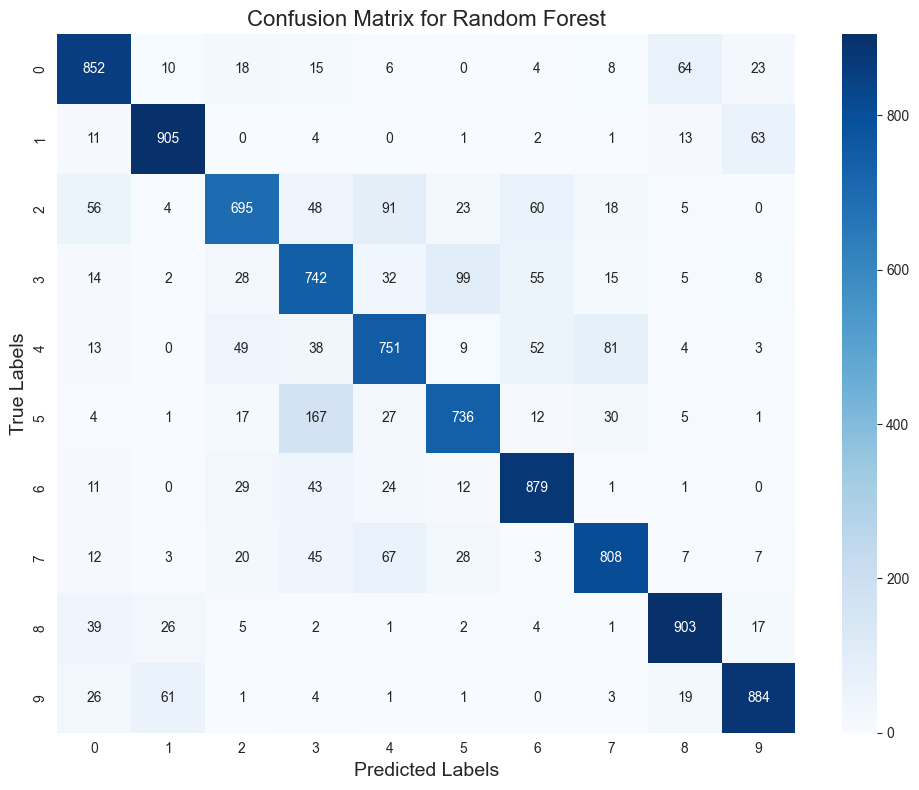

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 混淆矩阵和分类报告函数
def evaluate_and_visualize(y_test, y_pred, model_name):
    # 混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred, digits=4))
    
    # 可视化混淆矩阵
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.title(f"Confusion Matrix for {model_name}", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.tight_layout()
    plt.show()

# LG 混淆矩阵和分类报告
print("Evaluating log...")
y_pred_knn = log_reg.predict(X_test)
evaluate_and_visualize(y_test, y_pred_knn, "log")

# LightGBM 混淆矩阵和分类报告
print("Evaluating LightGBM...")
evaluate_and_visualize(y_test, y_pred_lgb, "LightGBM")

# 随机森林 混淆矩阵和分类报告
print("Evaluating Random Forest...")
y_pred_rf = random_forest.predict(X_test)
evaluate_and_visualize(y_test, y_pred_rf, "Random Forest")


In [ ]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# 数据预处理：标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optuna 调参目标函数
def objective(trial):
    # 定义超参数搜索空间
    penalty = trial.suggest_categorical('penalty', ['l2', 'none'])  # 正则化类型
    C = trial.suggest_float('C', 0.01, 10.0, log=True)  # 正则化强度
    max_iter = trial.suggest_int('max_iter', 500, 2000)  # 最大迭代次数

    # 初始化逻辑回归模型
    model = LogisticRegression(
        penalty=penalty,
        C=C,
        max_iter=max_iter,
        random_state=42,
        solver='lbfgs',  # 支持多分类
        multi_class='multinomial'
    )
    
    # 训练模型
    model.fit(X_train_scaled, y_train)
    
    # 验证集预测
    y_pred = model.predict(X_test_scaled)
    
    # 返回准确率作为优化目标
    return accuracy_score(y_test, y_pred)

# 进行参数调优
print("Starting Optuna parameter tuning...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# 最佳参数和最佳准确率
best_params = study.best_params
best_accuracy = study.best_value
print("\nBest parameters found by Optuna:")
print(best_params)
print(f"Best accuracy: {best_accuracy:.4f}")

# 使用最佳参数重新训练逻辑回归
print("Retraining Logistic Regression with best parameters...")
best_model = LogisticRegression(
    penalty=best_params['penalty'],
    C=best_params['C'],
    max_iter=best_params['max_iter'],
    random_state=42,
    solver='lbfgs',
    multi_class='multinomial'
)
best_model.fit(X_train_scaled, y_train)
y_pred_best = best_model.predict(X_test_scaled)

# 分类报告和混淆矩阵
print("\nBest Logistic Regression Classification Report:\n")
print(classification_report(y_test, y_pred_best, digits=4))

# 混淆矩阵可视化
def visualize_confusion_matrix(y_true, y_pred, model_name="Best Logistic Regression"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=range(5), yticklabels=range(5))
    plt.title(f"Confusion Matrix for {model_name}", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_confusion_matrix(y_test, y_pred_best, model_name="Best Logistic Regression")


[I 2024-12-10 02:14:56,186] A new study created in memory with name: no-name-788498a7-b3dd-4967-8ef4-67c13fe0501f


Starting Optuna parameter tuning...


[I 2024-12-10 02:15:15,579] Trial 0 finished with value: 0.869 and parameters: {'penalty': 'l2', 'C': 2.224238019582291, 'max_iter': 1355}. Best is trial 0 with value: 0.869.
D:\Anaconda\envs\pytorch_xiufu\lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
D:\Anaconda\envs\pytorch_xiufu\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2024-12-10 02:15:35,610] Trial 1 finished with value: 0.8681 and parameters: {'penalty': 'none', 'C': 3.14331340667316, 'max_iter': 664}. Best is trial 0 with value: 0.869.
[I 2024-12-10 02:15:51,518] Trial 2 finished with value: 0.869 and parameters: {'penalty': 'l2', 'C': 0.7603127581803314, 'max_iter': 1491}. Best is trial 0 with value: 0.869.
D:\Anaconda\envs\pytorch_xiufu\lib\site-packages\sk

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Samual\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Samual\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch [1/10], Train Loss: 1.1228, Test Loss: 0.9558, Train Acc: 0.9112, Test Acc: 0.9663
Epoch [2/10], Train Loss: 0.9162, Test Loss: 0.9449, Train Acc: 0.9949, Test Acc: 0.9708
Epoch [3/10], Train Loss: 0.9083, Test Loss: 0.9426, Train Acc: 0.9983, Test Acc: 0.9685
Epoch [4/10], Train Loss: 0.9071, Test Loss: 0.9408, Train Acc: 0.9989, Test Acc: 0.9685
Epoch [5/10], Train Loss: 0.9062, Test Loss: 0.9401, Train Acc: 0.9994, Test Acc: 0.9685
Epoch [6/10], Train Loss: 0.9060, Test Loss: 0.9398, Train Acc: 0.9994, Test Acc: 0.9685
Epoch [7/10], Train Loss: 0.9058, Test Loss: 0.9395, Train Acc: 0.9994, Test Acc: 0.9685
Epoch [8/10], Train Loss: 0.9057, Test Loss: 0.9393, Train Acc: 0.9994, Test Acc: 0.9685
Epoch [9/10], Train Loss: 0.9057, Test Loss: 0.9391, Train Acc: 0.9994, Test Acc: 0.9685
Epoch [10/10], Train Loss: 0.9056, Test Loss: 0.9390, Train Acc: 0.9994, Test Acc: 0.9685


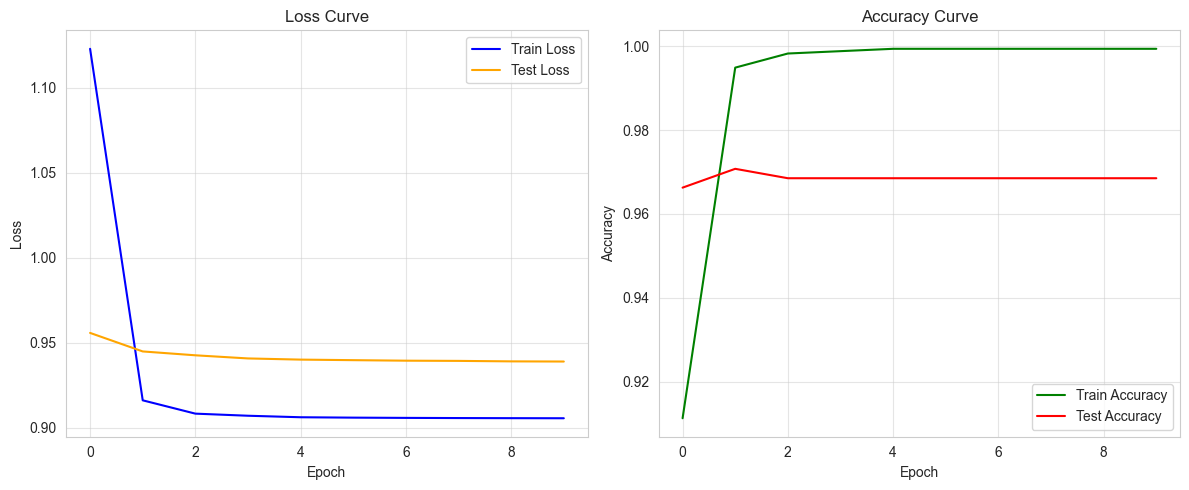


Classification Report:

               precision    recall  f1-score   support

     business     0.9487    0.9652    0.9569       115
entertainment     0.9595    0.9861    0.9726        72
     politics     0.9730    0.9474    0.9600        76
        sport     0.9902    0.9902    0.9902       102
         tech     0.9744    0.9500    0.9620        80

     accuracy                         0.9685       445
    macro avg     0.9691    0.9678    0.9683       445
 weighted avg     0.9687    0.9685    0.9685       445



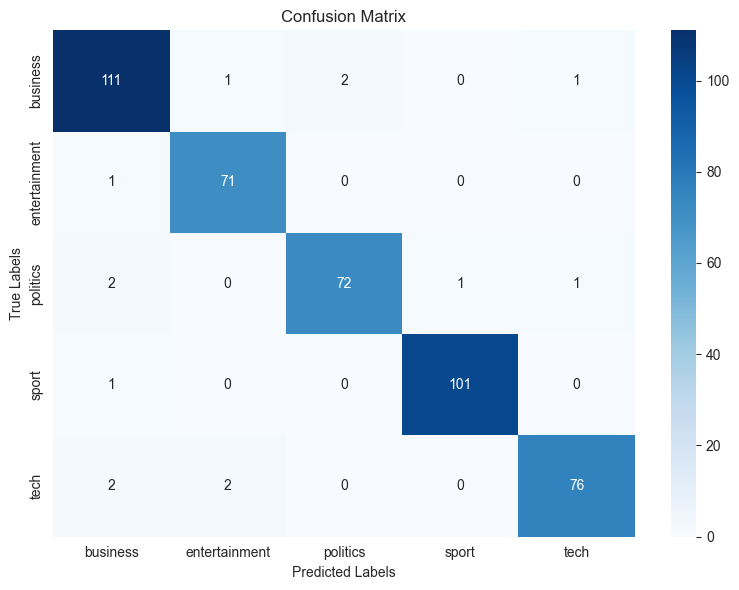

In [21]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

# nltk 数据下载
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# 数据集加载
def load_bbc_dataset(base_path):
    texts, labels = [], []
    label_map = {"business": 0, "entertainment": 1, "politics": 2, "sport": 3, "tech": 4}
    for label, label_id in label_map.items():
        folder = os.path.join(base_path, label)
        for file in os.listdir(folder):
            file_path = os.path.join(folder, file)
            with open(file_path, 'r', encoding='latin1') as f:
                texts.append(f.read())
                labels.append(label_id)
    return texts, labels

# 数据预处理
def preprocess_text(texts):
    stop_words = set(stopwords.words('english'))
    preprocessed_texts = []
    for text in texts:
        # 转小写，移除标点
        text = re.sub(r'[^\w\s]', '', text.lower())
        # 分词
        words = word_tokenize(text)
        # 移除停用词
        words = [word for word in words if word not in stop_words]
        preprocessed_texts.append(' '.join(words))
    return preprocessed_texts

# 自定义数据集类
class BBCDataset(Dataset):
    def __init__(self, texts, labels, vectorizer):
        self.texts = vectorizer.transform(texts).toarray()
        self.labels = np.array(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# 神经网络模型
class TextClassificationModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(TextClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)

# 加载数据
base_path = "./"  # 替换为 BBC 数据集的根路径
texts, labels = load_bbc_dataset(base_path)

# 数据预处理
texts = preprocess_text(texts)

# 特征提取
vectorizer = CountVectorizer(max_features=5000)  # 选择前 5000 个最常见词
vectorizer.fit(texts)

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# 创建数据加载器
train_dataset = BBCDataset(X_train, y_train, vectorizer)
test_dataset = BBCDataset(X_test, y_test, vectorizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 模型训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextClassificationModel(input_dim=5000, hidden_dim=128, num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练过程 (记录训练和测试集的损失)
def train_model_with_loss(model, train_loader, test_loader, num_epochs=10):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss, correct, total = 0, 0, 0

        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # 验证集损失和准确率
        model.eval()
        total_test_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for texts, labels in test_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss = total_test_loss / len(test_loader)
        test_accuracy = correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies

# 训练模型


# 模型评估
def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# 训练模型
num_epochs = 10
train_losses, test_losses, train_accuracies, test_accuracies = train_model_with_loss(model, train_loader, test_loader, num_epochs)
# 绘制损失曲线和准确率曲线
def plot_metrics_with_test(train_losses, test_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 5))

    # Loss 曲线
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='orange')
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.5)

    # Accuracy 曲线
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy", color='green')
    plt.plot(test_accuracies, label="Test Accuracy", color='red')
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(alpha=0.5)

    plt.tight_layout()
    plt.show()

plot_metrics_with_test(train_losses, test_losses, train_accuracies, test_accuracies)

# 混淆矩阵和分类报告
def confusion_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, digits=4, target_names=["business", "entertainment", "politics", "sport", "tech"]))

    # 混淆矩阵可视化
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["business", "entertainment", "politics", "sport", "tech"], yticklabels=["business", "entertainment", "politics", "sport", "tech"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()

confusion_and_report(model, test_loader)


Training optimized model...
Epoch [1/100], Train Loss: 1.2208, Test Loss: 0.9948, Train Acc: 0.8152, Test Acc: 0.9663
Epoch [2/100], Train Loss: 0.9781, Test Loss: 0.9568, Train Acc: 0.9770, Test Acc: 0.9551
Epoch [3/100], Train Loss: 0.9333, Test Loss: 0.9530, Train Acc: 0.9933, Test Acc: 0.9573
Epoch [4/100], Train Loss: 0.9247, Test Loss: 0.9465, Train Acc: 0.9949, Test Acc: 0.9663
Epoch [5/100], Train Loss: 0.9170, Test Loss: 0.9435, Train Acc: 0.9983, Test Acc: 0.9596
Epoch [6/100], Train Loss: 0.9130, Test Loss: 0.9425, Train Acc: 0.9983, Test Acc: 0.9685
Epoch [7/100], Train Loss: 0.9141, Test Loss: 0.9438, Train Acc: 0.9972, Test Acc: 0.9618
Epoch [8/100], Train Loss: 0.9122, Test Loss: 0.9423, Train Acc: 0.9994, Test Acc: 0.9663
Epoch [9/100], Train Loss: 0.9094, Test Loss: 0.9417, Train Acc: 0.9994, Test Acc: 0.9640
Epoch [10/100], Train Loss: 0.9090, Test Loss: 0.9406, Train Acc: 0.9989, Test Acc: 0.9663
Epoch [11/100], Train Loss: 0.9089, Test Loss: 0.9413, Train Acc: 1.000

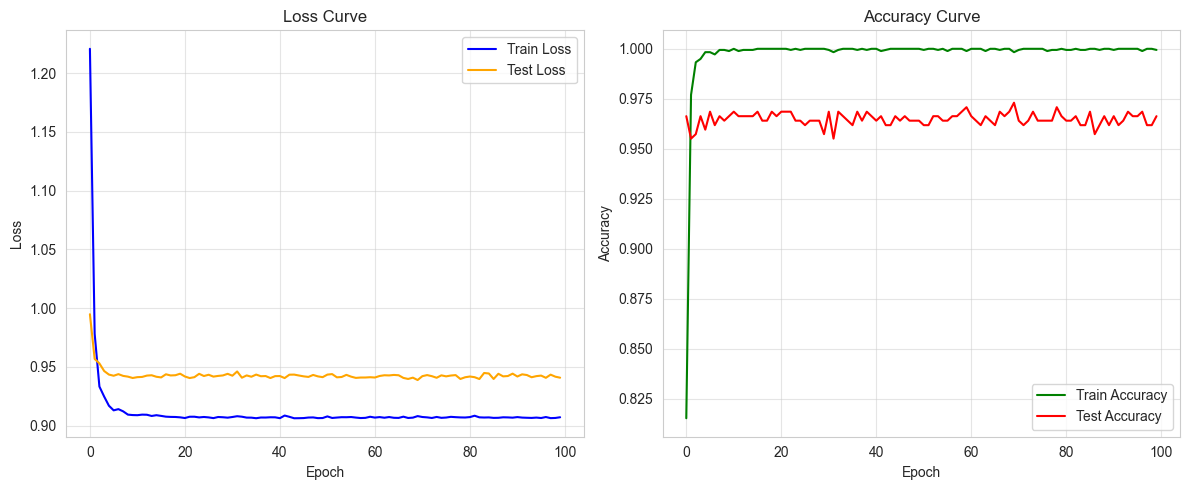


Classification Report:

               precision    recall  f1-score   support

     business     0.9820    0.9478    0.9646       115
entertainment     0.9231    1.0000    0.9600        72
     politics     0.9605    0.9605    0.9605        76
        sport     0.9806    0.9902    0.9854       102
         tech     0.9740    0.9375    0.9554        80

     accuracy                         0.9663       445
    macro avg     0.9640    0.9672    0.9652       445
 weighted avg     0.9670    0.9663    0.9663       445



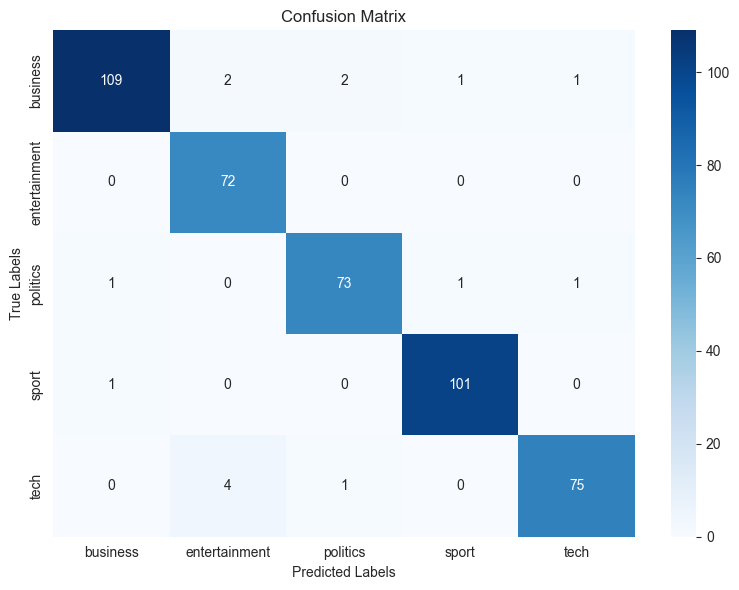

In [26]:
# 优化的神经网络模型
class OptimizedTextClassificationModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, num_classes):
        super(OptimizedTextClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(hidden_dim2, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        return self.softmax(x)

# 初始化优化后的模型
model = OptimizedTextClassificationModel(input_dim=5000, hidden_dim1=256, hidden_dim2=128, num_classes=5).to(device)

# 优化器和学习率调度器
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # 每5个epoch学习率减半

# 训练过程 (添加调度器)
def train_model_with_scheduler(model, train_loader, test_loader, num_epochs=10):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss, correct, total = 0, 0, 0

        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # 验证集损失和准确率
        model.eval()
        total_test_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for texts, labels in test_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss = total_test_loss / len(test_loader)
        test_accuracy = correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # 更新学习率
        scheduler.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies

# 训练优化后的模型
print("Training optimized model...")
train_losses, test_losses, train_accuracies, test_accuracies = train_model_with_scheduler(model, train_loader, test_loader, 100)

# 绘制损失曲线和准确率曲线
plot_metrics_with_test(train_losses, test_losses, train_accuracies, test_accuracies)

# 混淆矩阵和分类报告
confusion_and_report(model, test_loader)
